In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Set CUDA_LAUNCH_BLOCKING environment variable
!export CUDA_LAUNCH_BLOCKING=1

In [4]:
# Set your custom dataset path
data_dir = "gdrive/MyDrive/Colab Notebooks/ucb_capstone_asd_detection/data"

In [36]:
# Set the number of classes in your dataset
num_classes = 3

# Set batch size, number of epochs, and learning rate
batch_size = 16
num_epochs = 20
learning_rate = 1e-4

In [8]:
average  = torch.Tensor([0,0,0])
standard_dev = torch.Tensor([0,0,0])
images = ImageFolder(data_dir+'/train', transforms.ToTensor())
for image in images:
    average += image[0].mean([1,2])
    standard_dev += image[0].std([1,2])
average / len(images) , standard_dev / len(images)

(tensor([0.0013, 0.0014, 0.0011]), tensor([0.0100, 0.0114, 0.0106]))

In [9]:
stats = ((average / len(images)).tolist(), (standard_dev / len(images)).tolist())
data_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(*stats,inplace=True)
                                    ])

In [10]:
# Load your custom dataset
image_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

In [11]:
# Split the dataset into train and validation sets
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])

In [14]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [15]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


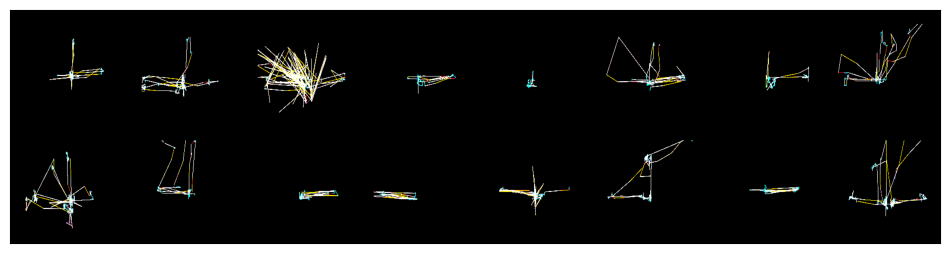

In [16]:
show_batch(train_loader);

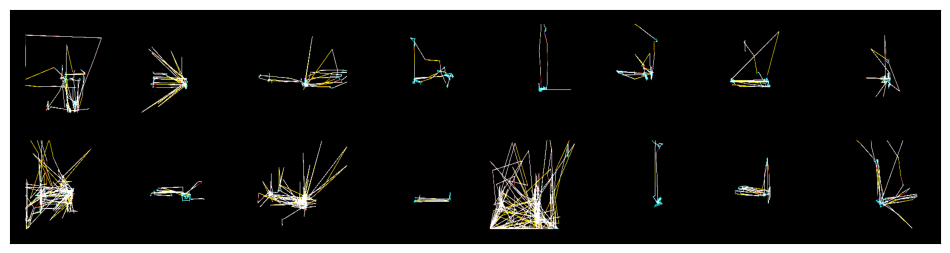

In [17]:
show_batch(val_loader);

In [21]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Max-pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)  # 2 classes for binary classification

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(-1, 64 * 28 * 28)  # Flatten the output for the fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.softmax(x)

        return x

In [22]:
# Instantiate the model
model = CNNModel()

In [39]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [40]:
# Training loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation step
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_accuracy:.2f}% "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_accuracy:.2f}%")


Epoch [1/20] Train Loss: 0.4070 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
Epoch [2/20] Train Loss: 0.4070 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
Epoch [3/20] Train Loss: 0.4168 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
Epoch [4/20] Train Loss: 0.4119 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
Epoch [5/20] Train Loss: 0.4070 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
Epoch [6/20] Train Loss: 0.4070 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
Epoch [7/20] Train Loss: 0.4119 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
Epoch [8/20] Train Loss: 0.4119 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
Epoch [9/20] Train Loss: 0.4070 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
Epoch [10/20] Train Loss: 0.4119 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
Epoch [11/20] Train Loss: 0.4070 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
Epoch [12/20] Train Loss: 0.4070 Train Acc: 90.39% Val Loss: 0.4332 Val Acc: 88.18%
E

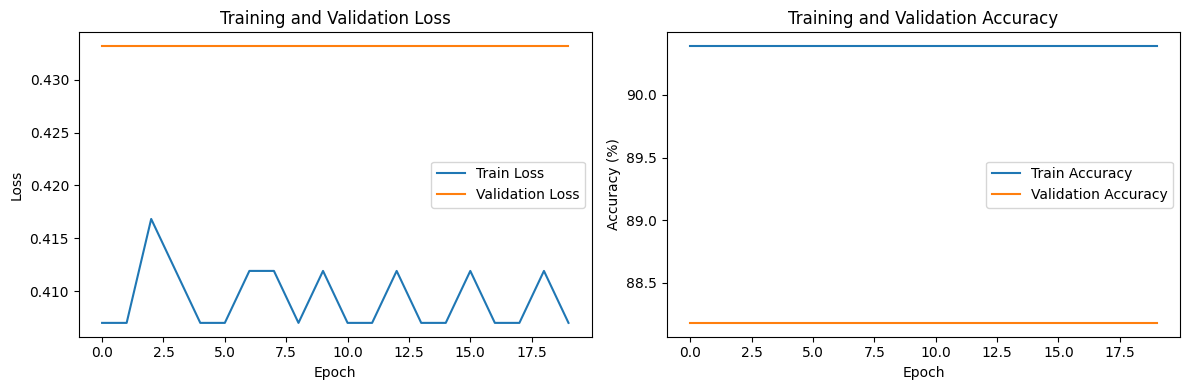

In [41]:
# Plot the training and validation losses and accuracies
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [42]:
# Save the trained model to a file
torch.save(model.state_dict(), 'trained_model.pth')